## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Exponential Smoothening
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Autocorrelation
from statsmodels.stats.stattools import durbin_watson

# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Model Building
## Auto Regression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

## Importing Dataset

In [2]:
#read data
data = pd.read_csv(r'C:\Users\amarc\Downloads\Praxis\2nd sem\TSF\ET\TFdata.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,19-08-2002,5.07,5.07,4.86,4.91,3.65,205880.0
1,28-10-2002,5.00,5.05,4.92,4.96,3.69,134504.0
2,29-10-2002,4.94,5.04,4.92,5.00,3.72,143024.0
3,16-08-2002,5.02,5.26,4.94,5.03,3.74,811856.0
4,25-10-2002,5.05,5.13,5.02,5.03,3.74,172296.0


In [3]:
#checking for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4725 entries, 0 to 4724
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4709 non-null   object 
 1   Open       4709 non-null   float64
 2   High       4709 non-null   float64
 3   Low        4709 non-null   float64
 4   Close      4709 non-null   float64
 5   Adj Close  4709 non-null   float64
 6   Volume     4709 non-null   float64
dtypes: float64(6), object(1)
memory usage: 258.5+ KB


In [4]:
#confirming absence of null values
data.isnull().sum()

Date         16
Open         16
High         16
Low          16
Close        16
Adj Close    16
Volume       16
dtype: int64

In [5]:
# imputing using the rolling average
df = data.assign(close=data.Close.fillna(data.Close.rolling(24,min_periods=1,).mean()))

In [6]:
df.isnull().sum()

Date         16
Open         16
High         16
Low          16
Close        16
Adj Close    16
Volume       16
close         0
dtype: int64

In [7]:
df = df.drop(['Date','Open','High','Low','Adj Close','Volume','Close'],axis=1)
df

,close
0,4.910000
1,4.960000
2,5.000000
3,5.030000
4,5.030000
...,...
4720,461.409167
4721,461.750909
4722,462.043000
4723,462.393333


In [8]:
close = df[['close']]
close

,close
0,4.910000
1,4.960000
2,5.000000
3,5.030000
4,5.030000
...,...
4720,461.409167
4721,461.750909
4722,462.043000
4723,462.393333


In [9]:
#final check of null values
close.isnull().sum()

close    0
dtype: int64

In [10]:
#Summary statistics of the data
close.describe()

,close
count,4725.000000
mean,121.588604
std,112.314717
min,4.910000
25%,29.460000
50%,81.700000
75%,176.370000
max,467.610000


In [11]:
close.head()

,close
0,4.91
1,4.96
2,5.00
3,5.03
4,5.03


In [12]:
close.tail()

,close
4720,461.409167
4721,461.750909
4722,462.043000
4723,462.393333
4724,462.775000


## 1 Line plot

<Axes: >

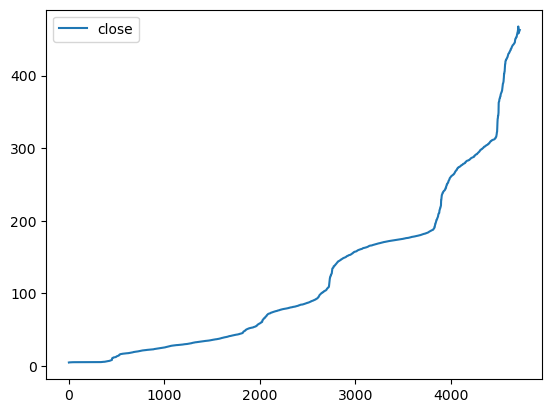

In [13]:
#visualization of time series data
close.plot()

<Axes: >

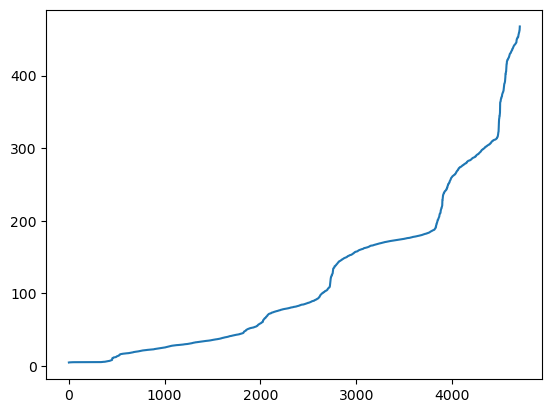

In [14]:
data['Close'].plot()

This plot shows the variation in Closing price across the years

1.Trend - There is a trend as can be seen in the plot the closing price is increasing

## 2 Seasonal Decomposition

### a.  Additive model

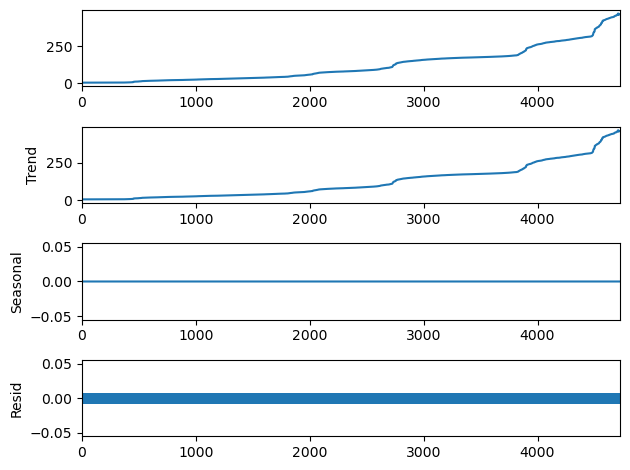

In [15]:
#decomposing trend, level, seasonality in data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x=close,period=1,model='additive') #period of 1 year to check seasonality
decomposition.plot()
plt.show()

### b.Multiplicative model

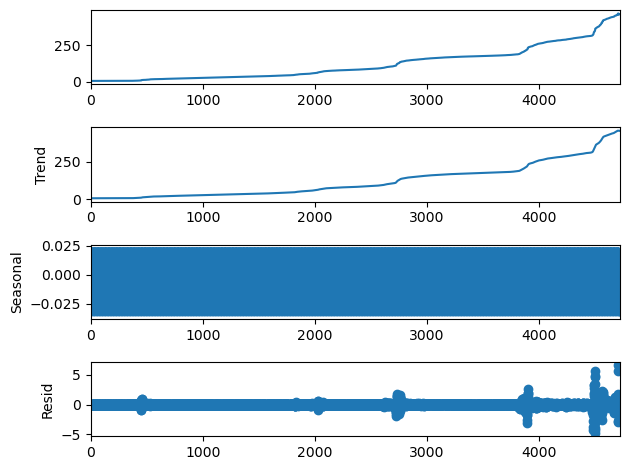

In [16]:
#decomposing trend, level, seasonality in data
decomposition = seasonal_decompose(x=close,period=14,model='additive')  #14 years of data
decomposition.plot()
plt.show()

Seasonality is not observable

Sice residulas in both additive and multiplicative model are centered around 0 so the data is not a additive or multiplicative model

In [17]:
#confirming stationarity through Ad-Fuller test

#Checking for stationarity with ADF test

#ADF Test (left tail test on the DF distribution):
#Null: Series is not stationary i.e. unit root exists
#Alt: Series is stationary ie unit root does not exist

from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(close)
# Print test statistic
print('tset stat:',result[0])

# Print p-value
print('p-value:',result[1])

# Print critical values for different significance levels
print('Critical Values:',result[4]) 


tset stat: 4.135364710524816
p-value: 1.0
Critical Values: {'1%': -3.4317444759563105, '5%': -2.862156198679841, '10%': -2.5670980048334617}


In [18]:
#Since p-value>0.05, we fail to reject the null that series is not stationary. We have to stationarize the series through differencing.

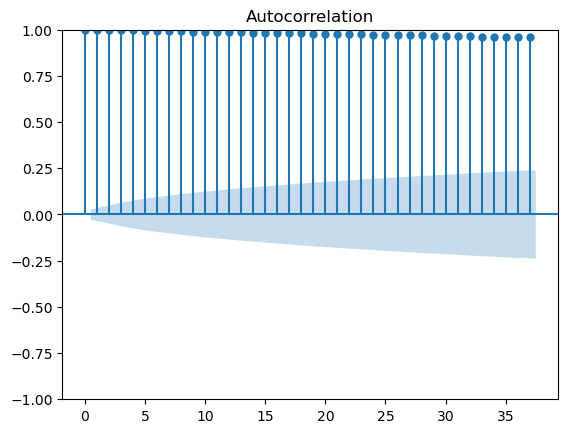

In [19]:
#Let's also check if there is autocorrelation in the non-stationary series 
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(close.close)
plt.show()

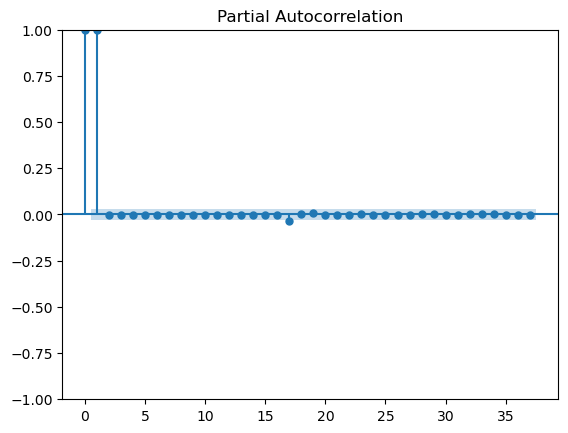

In [20]:
fig = tsaplots.plot_pacf(close.close)
plt.show()

In [21]:
#The high ACF across lags but high PACF only from lags 1-3 show that the effects of the first and/or second time periods is carrying forward to the next time periods. The ACF clearly shows that the curren time period is autocorrelated only with the 1-4th time lags.

In [22]:
#single-order differencing of the series
close['Diff']=close.diff() 

In [23]:
#dropping nan values
close_diff=close.dropna()

In [24]:
close_diff

,close,Diff
1,4.960000,0.050000
2,5.000000,0.040000
3,5.030000,0.030000
4,5.030000,0.000000
5,5.040000,0.010000
...,...,...
4720,461.409167,0.349936
4721,461.750909,0.341742
4722,462.043000,0.292091
4723,462.393333,0.350333


<Axes: >

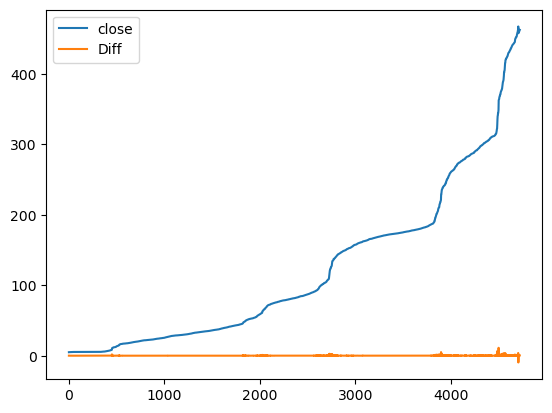

In [25]:
close_diff.plot() #the series now looks stationary but let's confirm with the Ad-fuller test

In [26]:
# Run test
result = adfuller(close_diff['Diff'])
# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values for different significance levels
print(result[4]) 

-6.537862282550862
9.508678296387215e-09
{'1%': -3.4317444759563105, '5%': -2.862156198679841, '10%': -2.5670980048334617}


In [27]:
#Since pvalue<0.05, we can now reject the null hypothesis that the series is not stationary. We have sufficient evidence to say that the series is not non-stationary.

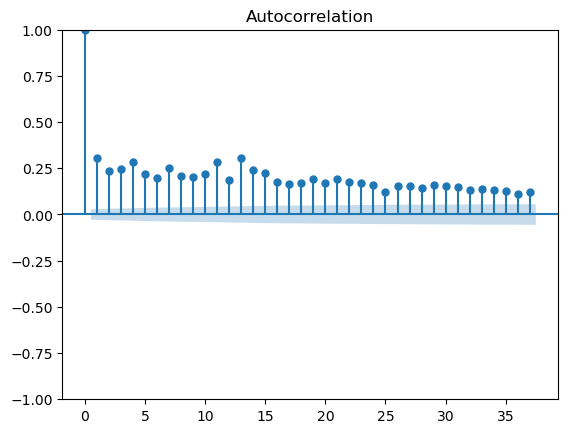

In [28]:
#Let's check the new ACF,PACF plots of the differenced,stationary data
fig = tsaplots.plot_acf(close_diff['Diff'])
plt.show()



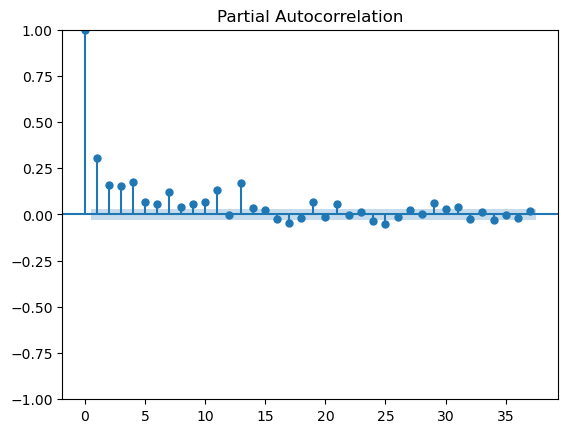

In [29]:
fig = tsaplots.plot_pacf(close_diff['Diff'],method='OLS')
plt.show()

In [30]:
#There is a  cutoff in the ACF plot of the differenced  series, which indicates an MA model of order 1.


## 3 Train-test split

In [31]:
#train-test split to make forecasts and find errors 
train=pd.DataFrame(close['close'][0:4544])
test=pd.DataFrame(close['close'][4544:4724])
y_hat = test.copy() # Just not to spoil the main test file

## 4 Heuristic Models

In [32]:
df_models = pd.DataFrame(columns = ["Model Number", "Model Name", "MSE", 
                                    'MAPE', 'RMSE', 'MAE'])

### 1 Naive Forecast

In [33]:
temp = np.asarray(train.close)
y_hat['naive'] = temp[len(temp)-1]

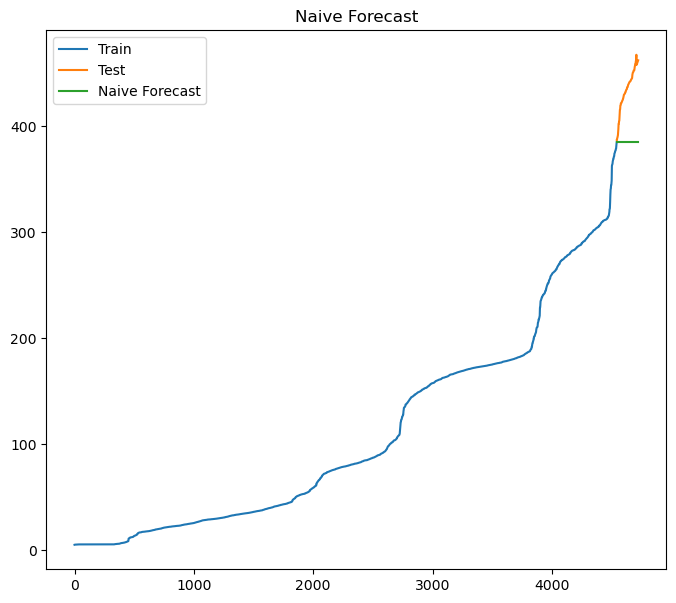

In [34]:
plt.figure(figsize=(8,7))
plt.plot(train.index, train['close'], label='Train')
plt.plot(test.index,test['close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [35]:
mse = mean_squared_error(test.close, y_hat.naive)
mape = np.mean(np.abs((test.close - y_hat.naive) / y_hat.naive)) * 100
rmse = sqrt(mean_squared_error(test.close, y_hat.naive))
mae= mean_absolute_error(test.close, y_hat.naive)
df_models = df_models.append({"Model Number":1, "Model Name":'Naive Forecast', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

### 2 Simple Average

In [36]:
y_hat['avg_forecast'] = train['close'].mean()

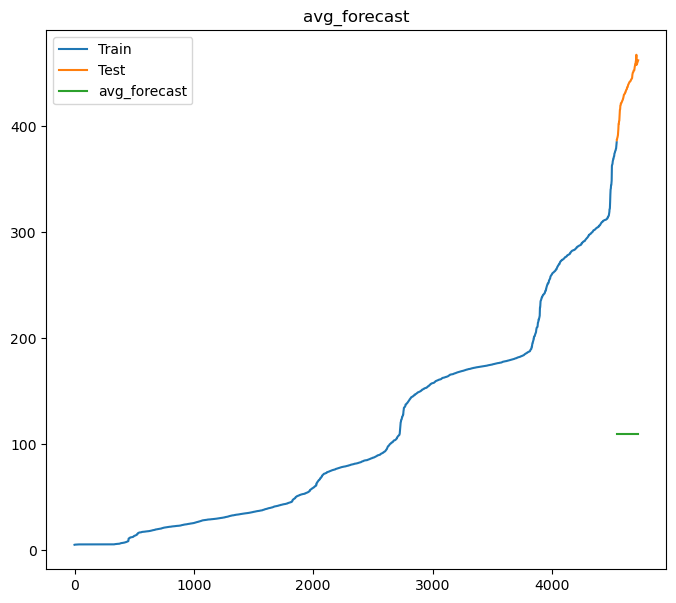

In [37]:
plt.figure(figsize=(8,7))
plt.plot(train.index, train['close'], label='Train')
plt.plot(test.index,test['close'], label='Test')
plt.plot(y_hat.index,y_hat['avg_forecast'], label='avg_forecast')
plt.legend(loc='best')
plt.title("avg_forecast")
plt.show()

In [38]:
mse = mean_squared_error(test.close, y_hat.avg_forecast)
mape = np.mean(np.abs((test.close - y_hat.avg_forecast) / y_hat.avg_forecast)) * 100
rmse = sqrt(mean_squared_error(test.close, y_hat.avg_forecast))
mae= mean_absolute_error(test.close, y_hat.avg_forecast)
df_models = df_models.append({"Model Number":2, "Model Name":'Average Forecast', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

### 3 Simple Moving Average

In [39]:
y_hat_sma = close.copy()
y_hat_sma['sma_forecast'] = close['close'].rolling(3).mean()
y_hat_sma['sma_forecast'][len(train):] = y_hat_sma['sma_forecast'][len(train)-1]

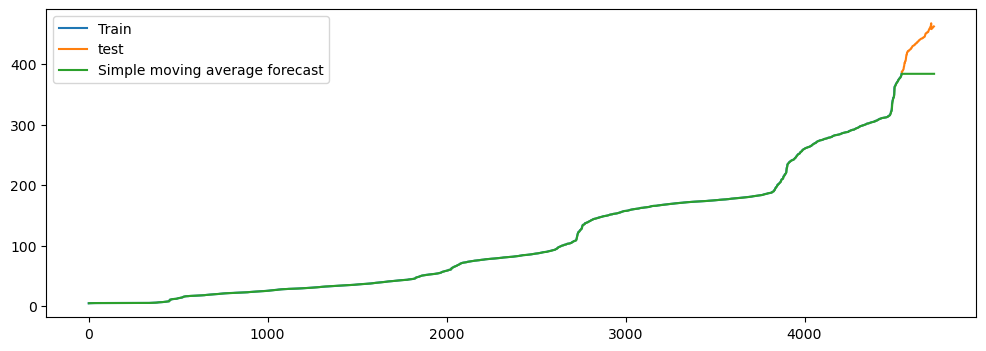

In [40]:
plt.figure(figsize=(12,4))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

In [41]:
len(y_hat_sma)

4725

In [42]:
# mse = mean_squared_error(test.close, y_hat_sma['sma_forecast'][len(train):])
# mape = np.mean(np.abs((test.close - y_hat_sma['sma_forecast'][len(train):]) / y_hat_sma['sma_forecast'][len(train):])) * 100
# rmse = sqrt(mean_squared_error(test.close, y_hat_sma['sma_forecast'][len(train):]))
# mae= mean_absolute_error(test.close, y_hat_sma['sma_forecast'][len(train):])
# df_models = df_models.append({"Model Number":3, "Model Name":'SMA Forecast', 'MSE':mse, 
#                               'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

## Exponential Smoothing

### 1 Simple Exponential Smoothing

In [43]:
# Instantiate the model
model = SimpleExpSmoothing(train['close'])
# Fit the model with alpha = 0.2 
# optimized = False means, we are explicitly definign the smoothing_level.
# optimized = True means - Automitacially it will define a smoothing_level based on RMSE
model_fit = model.fit(smoothing_level = 0.2, optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 4.91,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Optimal alpha=0.2

We gat an optimum forecasted line.

In [44]:
y_hat_ses = test.copy()
# Forecast for 6 months
y_hat_ses['ses_forecast'] = model_fit.forecast(len(y_hat_ses))

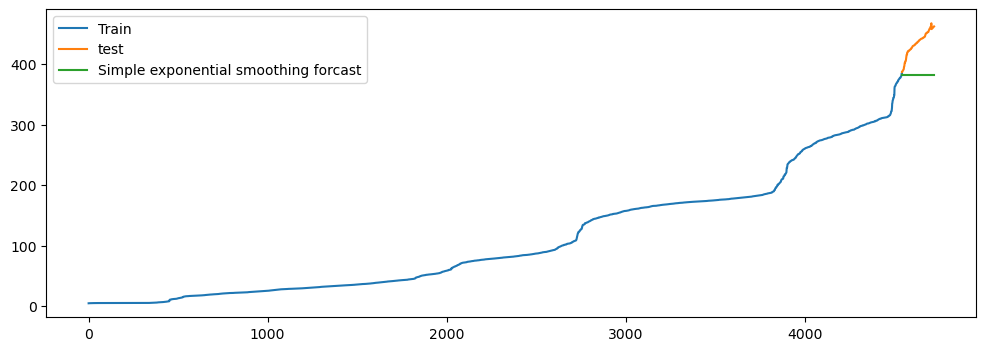

In [45]:
plt.figure(figsize=(12,4))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [46]:
mse = mean_squared_error(test.close, y_hat_ses['ses_forecast'])
mape = np.mean(np.abs((test.close - y_hat_ses['ses_forecast']) / y_hat_ses['ses_forecast'])) * 100
rmse = sqrt(mean_squared_error(test.close, y_hat_ses['ses_forecast']))
mae= mean_absolute_error(test.close, y_hat_ses['ses_forecast'])
df_models = df_models.append({"Model Number":3, "Model Name":'Simple Exponential Smootheing', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [47]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405


### 2  Holt's Exponential Smoothening

In [48]:
# We have to pass an array of the dataframe into the ExponentialSmoothing instance
# We are using multiplicative trend because, from the time decomposition we know that it is multiplicative model.
# seasonal=None Because we are not capturing seasonality in this model
model = ExponentialSmoothing(np.asarray(train['close']), seasonal_periods = 12, trend='multiplicative', seasonal=None)

In [49]:
# smoothing_level. It is the level parameter (alpha)
# smoothing_slope - It is the trend parameter (beta) 
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.01, optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': 0.01,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 4.935333333333331,
 'initial_trend': 1.003119128608795,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

smoothing_level: 0.2

smoothing_trend: 0.01

In [50]:
y_hat_holt = test.copy()
# We are forecasting for next 24 months
y_hat_holt['holt_forecast'] = model_fit.forecast(len(y_hat_holt))

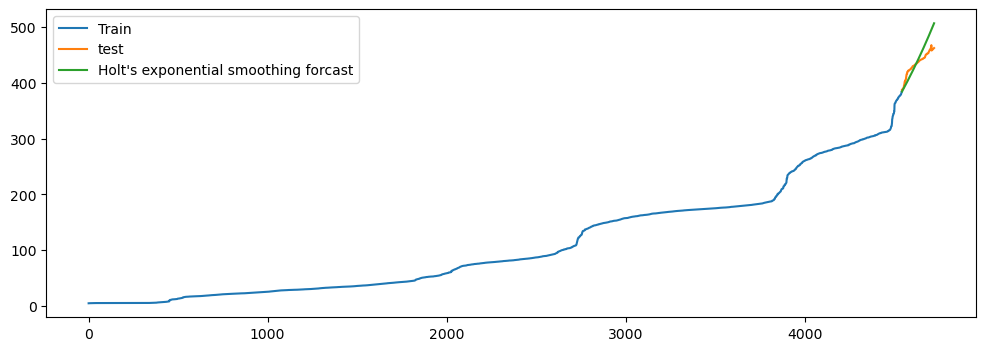

In [51]:
plt.figure(figsize=(12,4))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [52]:
mse = mean_squared_error(test.close, y_hat_holt['holt_forecast'])
mape = np.mean(np.abs((test.close - y_hat_holt['holt_forecast']) / y_hat_holt['holt_forecast'])) * 100
rmse = sqrt(mean_squared_error(test.close, y_hat_holt['holt_forecast']))
mae= mean_absolute_error(test.close, y_hat_holt['holt_forecast'])
df_models = df_models.append({"Model Number":4, "Model Name":'Holts Exponential Smootheing', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [53]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953


### Triple Exponential Smoothing

In [54]:
y_hat_hwm = test.copy()

# seasonal=mul for multiplicative method
# trend='add' . We are not changing the trend. We are only chaning the seasonal from additive to multiplicative.
model = ExponentialSmoothing(np.asarray(train['close']), seasonal_periods = 12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
model_fit.params

{'smoothing_level': 0.9999999850988387,
 'smoothing_trend': 0.13008079584650448,
 'smoothing_seasonal': 1.4589811286368877e-08,
 'damping_trend': nan,
 'initial_level': 6.694580120474535,
 'initial_trend': 0.09815500280289782,
 'initial_seasons': array([0.69216907, 0.69222522, 0.69245187, 0.6924959 , 0.69252237,
        0.69244417, 0.69243846, 0.69243023, 0.69228961, 0.69211906,
        0.69196021, 0.69206437]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [55]:
y_hat_hwm['hwm_forecast'] = model_fit.forecast(len(y_hat_hwm))

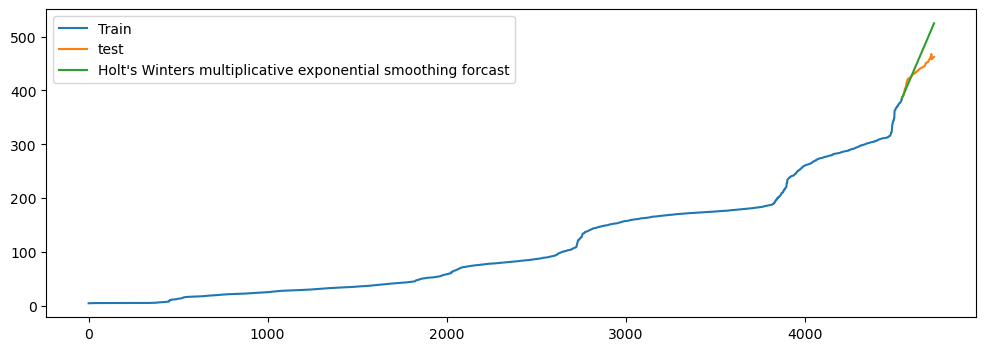

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt\'s Winters multiplicative exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [57]:
mse = mean_squared_error(test.close, y_hat_hwm['hwm_forecast'])
mape = np.mean(np.abs((test.close - y_hat_hwm['hwm_forecast']) / y_hat_hwm['hwm_forecast'])) * 100
rmse = sqrt(mean_squared_error(test.close, y_hat_hwm['hwm_forecast']))
mae= mean_absolute_error(test.close, y_hat_hwm['hwm_forecast'])
df_models = df_models.append({"Model Number":5, "Model Name":'Holts Winter Exponential Smootheing', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [58]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855


The Holts Exponetial smoothing is performing better in all 3 exponential smoothing

## Non- Heuristic Models

### 1 AR model

In [59]:
model = AutoReg(train, lags = 12).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  close   No. Observations:                 4544
Model:                    AutoReg(12)   Log Likelihood                -174.064
Method:               Conditional MLE   S.D. of innovations              0.251
Date:                Fri, 28 Jul 2023   AIC                            376.129
Time:                        23:16:56   BIC                            465.994
Sample:                            12   HQIC                           407.782
                                 4544                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.006     -0.053      0.958      -0.011       0.011
close.L1       1.1800      0.015     80.530      0.000       1.151       1.209
close.L2      -0.0100      0.023     -0.436      0.663      -0.055       0.035
close.L3      -0.1214      0.023     -5.269      0.000      -0.167      -0.076
close.L4       0.0020      0.023      0.084      0.933      -0.043       0.047
close.L5      -0.0570      0.023     -2.465      0.014      -0.102      -0.012
close.L6       0.0713      0.023      3.081      0.002       0.026       0.117
close.L7       0.0401      0.023      1.733      0.083      -0.005       0.085
close.L8      -0.1201      0.023     -5.192      0.000      -0.165      -0.075
close.L9      -0.0166      0.023     -0.713      0.476      -0.062       0.029
close.L10      0.0578      0.023      2.492      0.013       0.012       0.103
close.L11      0.1471      0.023      6.344      0.000       0.102       0.193
close.L12     -0.1730      0.015    -11.631      0.000      -0.202      -0.144
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1383           -0.3285j            1.1847           -0.4553
AR.2            -1.1383           +0.3285j            1.1847            0.4553
AR.3            -0.8216           -0.9181j            1.2321           -0.3662
AR.4            -0.8216           +0.9181j            1.2321            0.3662
AR.5            -0.1995           -1.1396j            1.1569           -0.2776
AR.6            -0.1995           +1.1396j            1.1569            0.2776
AR.7             0.5405           -1.0333j            1.1661           -0.1733
AR.8             0.5405           +1.0333j            1.1661            0.1733
AR.9             1.0177           -0.6166j            1.1899           -0.0867
AR.10            1.0177           +0.6166j            1.1899            0.0867
AR.11            0.9992           -0.0000j            0.9992           -0.0000
AR.12            1.0535           -0.0000j            1.0535           -0.0000
------------------------------------------------------------------------------
"""

In [60]:
pred = model.predict(start = len(train), end = len(close_diff['close'])-1, dynamic = False)

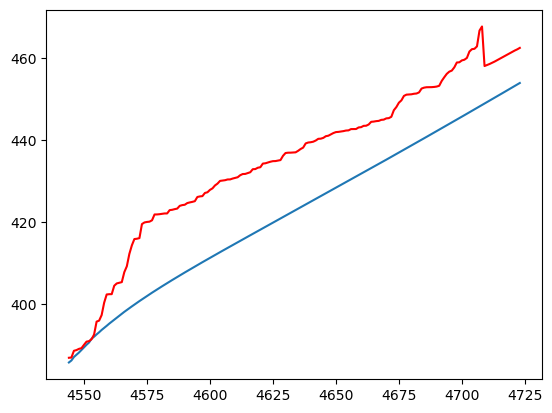

In [61]:
plt.plot(pred)
plt.plot(test, color = 'red')
plt.show()

In [62]:
pred = pd.DataFrame(pred)
pred = pred.rename({0:"close"},axis = 1)

In [63]:
mse = mean_squared_error(test.close, pred.close)
mape = np.mean(np.abs((test.close - pred.close) / pred.close)) * 100
rmse = sqrt(mean_squared_error(test.close, pred.close))
mae= mean_absolute_error(test.close, pred.close)
df_models = df_models.append({"Model Number":6, "Model Name":'AR Model', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [64]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855
5,6,AR Model,176.5031,2.970111,13.285447,12.547147


### 2 MA Model

In [65]:
arima_model = ARIMA(train, order = (0, 0, 1))  
modelfit = arima_model.fit()
pred = modelfit.forecast(steps = len(test))

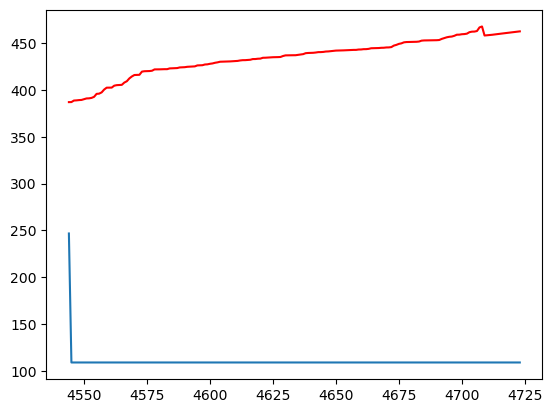

In [66]:
plt.plot(pred)
plt.plot(test, color = 'red')
plt.show()

In [67]:
pred = pd.DataFrame(pred)
pred = pred.rename({'predicted_mean':"close"},axis = 1)

In [68]:
mse = mean_squared_error(test.close, pred.close)
mape = np.mean(np.abs((test.close - pred.close) / pred.close)) * 100
rmse = sqrt(mean_squared_error(test.close, pred.close))
mae= mean_absolute_error(test.close, pred.close)
df_models = df_models.append({"Model Number":7, "Model Name":'MA Model', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [69]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855
5,6,AR Model,176.5031,2.970111,13.285447,12.547147
6,7,MA Model,106097.216027,297.25837,325.725676,324.852688


### 3 ARIMA Model

In [70]:
arima_model = ARIMA(train, order = (2, 0, 0))  
modelfit = arima_model.fit()
pred = modelfit.forecast(steps = len(test))

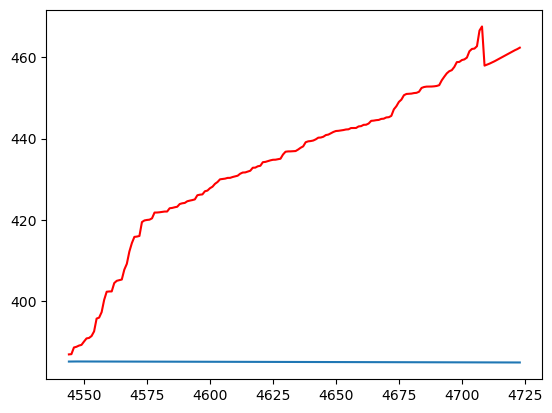

In [71]:
plt.plot(pred)
plt.plot(test, color = 'red')
plt.show()

In [72]:
pred = pd.DataFrame(pred)
pred = pred.rename({'predicted_mean':"close"},axis = 1)

In [73]:
mse = mean_squared_error(test.close, pred.close)
mape = np.mean(np.abs((test.close - pred.close) / pred.close)) * 100
rmse = sqrt(mean_squared_error(test.close, pred.close))
mae= mean_absolute_error(test.close, pred.close)
df_models = df_models.append({"Model Number":8, "Model Name":'MA Model', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [74]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855
5,6,AR Model,176.5031,2.970111,13.285447,12.547147
6,7,MA Model,106097.216027,297.25837,325.725676,324.852688
7,8,MA Model,2864.789711,12.913473,53.52373,49.71793


### 4 Auto Arima Model

In [75]:
# grid search and find best parameters
stepwise_fit = auto_arima(train, start_p = 0, 
                          start_q = 0, max_p = 3, max_q = 3,
                          trace = True, 
                          stationary = True,
                          error_action ='ignore', 
                          suppress_warnings = True, 
                          information_criterion='aic',
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54288.742, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=4.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58106.841, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1609.773, Time=6.98 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1270.364, Time=8.68 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.44 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.32 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1120.644, Time=10.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1117.805, Time=6.97 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=8.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1268.231, Time=5.05 sec
 A

According to Auto Arima model the model with least AIC is with the order (1,0,3)(0,0,0)

In [76]:
# Let's run the arima model on the order(1,0,3)

In [77]:
arima_model = ARIMA(train, order = (1,0,3))  
modelfit = arima_model.fit()
pred = modelfit.forecast(steps = len(test))

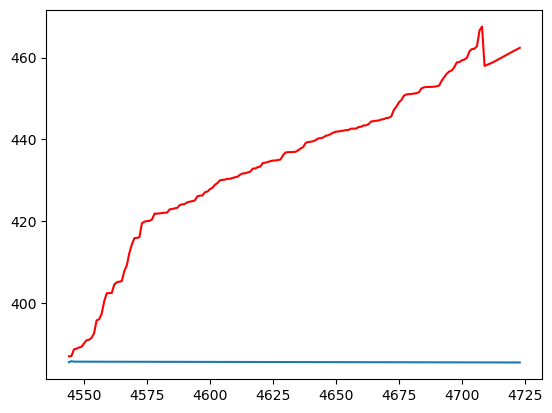

In [78]:
plt.plot(pred)
plt.plot(test, color = 'red')
plt.show()

In [79]:
pred = pd.DataFrame(pred)
pred = pred.rename({'predicted_mean':"close"},axis = 1)

In [80]:
mse = mean_squared_error(test.close, pred.close)
mape = np.mean(np.abs((test.close - pred.close) / pred.close)) * 100
rmse = sqrt(mean_squared_error(test.close, pred.close))
mae= mean_absolute_error(test.close, pred.close)
df_models = df_models.append({"Model Number":9, "Model Name":'ARIMA Model', 'MSE':mse, 
                              'MAPE':mape, 'RMSE':rmse, 'MAE':mae}, ignore_index=True)

In [81]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855
5,6,AR Model,176.5031,2.970111,13.285447,12.547147
6,7,MA Model,106097.216027,297.25837,325.725676,324.852688
7,8,MA Model,2864.789711,12.913473,53.52373,49.71793
8,9,ARIMA Model,2818.021097,12.776441,53.085036,49.250695


In [82]:
arima = ARIMA(train['close'], order=(1,0,3)).fit() #we take d=1 to stationarize the data and q=1 as it was the significant lag before shutdown
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 4544
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -553.453
Date:                Fri, 28 Jul 2023   AIC                           1118.907
Time:                        23:19:31   BIC                           1157.436
Sample:                             0   HQIC                          1132.476
                               - 4544                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.4714   2.97e-09   3.69e+10      0.000     109.471     109.471
ar.L1          1.0000   1.37e-05   7.29e+04      0.000       1.000       1.000
ma.L1          0.2683      0.003     90.830      0.000       0.262       0.274
ma.L2          0.2702      0.003    101.169      0.000       0.265       0.275
ma.L3          0.1775      0.004     42.059      0.000       0.169       0.186
sigma2         0.0745      0.000    484.172      0.000       0.074       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):          65752222.25
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              57.17   Skew:                            18.32
Prob(H) (two-sided):                  0.00   Kurtosis:                       591.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+22. Standard errors may be unstable.
"""

## Analysis of the Experiment

### 1 Residuals have constant variance

To check, we read the 'Heteroskedasticity' metric in ARIMA result. Our Ho is that no heteroskedasticity in residuals/ constant variance exists.

In our test results,p-value of 0.0<0.05, that is, so we reject the null hypothesis that constant variance exists

### 2 Normailty check for Residuals

<Axes: ylabel='Count'>

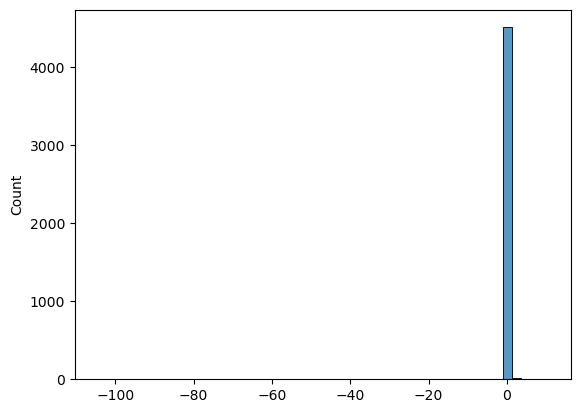

In [83]:
sns.histplot(arima.resid,bins=50) 

Residuals are not normally distributed.

### 3 The mean of Residuals is zero

In [84]:
arima.resid.mean()

0.02581151052613414

Mean of residuals is very  close to zero but not zero

### 4 The residuals are uncorrelated , no juice in residuals left to be modelled

To check: Ljung Box Test checks if the residuals are white noise or not wherein the null hypothesis states that Residuals are white noise.

In our test results, p-value is 0.79 which is greater than 0.05. Therefore, we fail to reject the hypothesis that results are white noise.

In [86]:
df_models

,Model Number,Model Name,MSE,MAPE,RMSE,MAE
0,1,Naive Forecast,2855.672195,12.893819,53.43849,49.654098
1,2,Average Forecast,106435.39675,298.461451,326.244382,325.645903
2,3,Simple Exponential Smootheing,3218.404535,13.937424,56.730984,53.181405
3,4,Holts Exponential Smootheing,373.184496,3.340599,19.317984,15.415953
4,5,Holts Winter Exponential Smootheing,895.753003,4.734561,29.929133,22.97855
5,6,AR Model,176.5031,2.970111,13.285447,12.547147
6,7,MA Model,106097.216027,297.25837,325.725676,324.852688
7,8,MA Model,2864.789711,12.913473,53.52373,49.71793
8,9,ARIMA Model,2818.021097,12.776441,53.085036,49.250695


## Conclusion

Among all the models Autoregression Model is performing better with an MAPE of 2.97% 

Amoung Heuristic Models Holts Exponential Smootheing model is better performing with an MAPE of 3.34%

Result of AR model is better so we should use AR model